In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader

import lib.pytorch_trainer as ptt

from src.imgnet_utils import denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)

from src.extractor_utils import (predict, getPrediction,features_saving,
                                 features_loading, torch_summarize)

from src.convnet_models import (MyResNet, MyInception, MyDenseNet)

In [49]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

4 GPU's available:

cpu_count: 24


In [50]:
use_gpu = False
use_DataParalel= True 
use_CPU= False         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 

if use_gpu:
    if use_DataParalel:
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
    else:
        print('Using only one GPU') #{} '.format(device_id))
else:
    print("Using {} CPU's".format(cpu_count))

Using 24 CPU's



# Choose dataset 

In [51]:
path2train = "/mnt/home/e209440/data/train" 

# Images transformation

In [52]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
}        

# Creating  Dataset & Dataloader

In [53]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset

In [56]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'], use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],  is_val=True, use_only=use_only)
}

In [57]:
dset_loaders = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= False)

# Plotting some examples

torch.Size([3, 300, 300]) torch.Size([32])


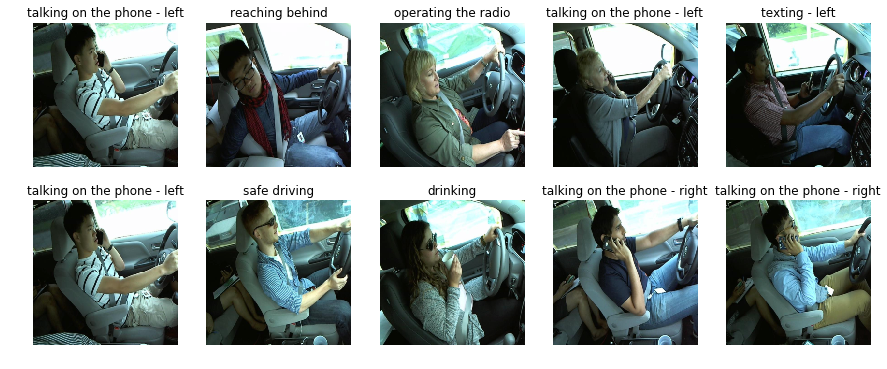

In [69]:
plot_classes(dset_loaders['train'])

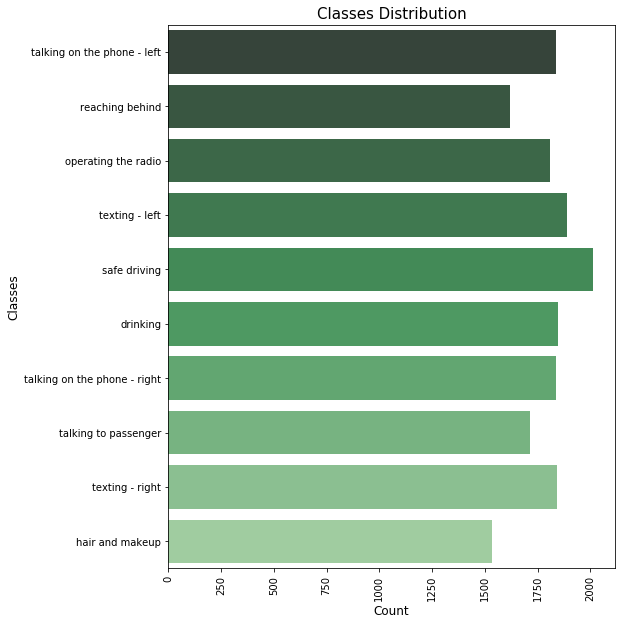

In [70]:
classDistribution(dsets['train'])

In [58]:
use_resnet = True
use_inception = False
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()

Using ResNet model


In [ ]:
plot_layers_weight(dsets,img_width=img_width, img_height=img_height,conv_model = model.mrnc,use_gpu=use_gpu)

# Mismatch predictions (validation)

In [59]:
path2results = "/mnt/home/r120084/project/state-farm-distracted-driver-detection/results"

In [60]:
print("Loaded features with shapes: \n")
npzfile = np.load(path2results+"/" + "results_valid_"+ model_name+ ".npz")

Loaded features with shapes: 



In [61]:
probas_matrix = torch.nn.functional.softmax(torch.from_numpy(npzfile['pred']))
probas, _ = torch.max(probas_matrix, 1)
probas = probas.data.numpy()

In [62]:
result_valid = {'probas': probas, 'pred': np.argmax(npzfile['pred'], 1), 'true': npzfile['true']}

In [63]:
i_egal = np.where(result_valid['true'] == result_valid['pred'])[0]
i_not_egal = np.where(result_valid['true'] != result_valid['pred'])[0]

### Right predictions with higher probability

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_egal])[::-1]
y_top = i_egal[top_predictions]

visualize_predictions(dsets['valid'], y_top,  result_valid)

###  Right forecasts with lower probability

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_egal])
y_bot = i_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot, result_valid)

### Wrong forecasts with higher probability

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])[::-1]
y_top_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_top_not, result_valid)

### Wrong forecasts with lower probability

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])
y_bot_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot_not, result_valid)

In [ ]:
# this cell it will be used to show what kind of transformations we have tried to do, do not move to a .py file because we will work on it yet.

composed = transforms.Compose([transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)])

composed1 = transforms.Compose([
                                transforms.CenterCrop((220,320)),
                                transforms.Scale((img_width, img_height)),
                                transforms.ToTensor(),
                                transforms.Normalize(imagenet_mean, imagenet_std)])

# Apply each of the above transforms on sample.
fig = plt.figure(figsize = (20,5))
for i, tsfrm in enumerate([composed, composed1]):
    dset_aux = KaggleSafeDriverDataset(path2train, transforms=tsfrm, use_only=use_only)
    (inputs, cls) = dset_aux[60]
    print(inputs.numpy().shape)
    img = denormalize(inputs.numpy())
    img = np.clip(img, 0, 1.0)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
statistical_analysis_image(dset_loaders['train'])

In [ ]:
# load the metrics of the train model (could be a csv file or something else) an plot them

In [ ]:
#load model and plot weights

In [ ]:
path2metrics = '/mnt/home/r120084/project/state-farm-distracted-driver-detection/metrics/metrics_Resnet18_2017-11-25-12-38.csv'
metrics = pd.read_csv(path2metrics).to_dict()

In [ ]:
#renaming dictionary keys
metrics['train']['acc'] = metrics['train'].pop(0)
metrics['train']['losses'] = metrics['train'].pop(1)

metrics['valid']['acc'] = metrics['valid'].pop(0)
metrics['valid']['losses'] = metrics['valid'].pop(1)

In [ ]:
plot_metrics(metrics)

In [ ]:
path2results = '/mnt/home/r120084/project/state-farm-distracted-driver-detection/results/results_Resnet18_2017-11-25-15-49.csv'
results = pd.read_csv(path2results).to_dict()

In [ ]:
import ast

#renaming dictionary keys
results['train']['pred'] = results['train'].pop(0)
results['train']['true'] = results['train'].pop(1) 

results['valid']['pred'] = results['valid'].pop(0)
results['valid']['true'] = results['valid'].pop(1)

In [ ]:
results